In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import functional
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from PIL import ImageStat

from keras.models import load_model
import tensorflow as tf
import cv2


from PIL import Image, ImageOps
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
from rembg import remove
from typing import cast, Any, Union, Dict, List
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

In [3]:
train_csv = pd.read_csv(r"Dataset_Mnist\fashion-mnist_train.csv")
test_csv = pd.read_csv(r"Dataset_Mnist\fashion-mnist_train.csv")

In [4]:
trainTransform1 = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomChoice([
        transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()]),
        transforms.Compose([transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip()]),
    ]),
    transforms.ToTensor()
])

trainTransform2 = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

testTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

In [5]:
# Import data
train_set1 = FashionDataset(train_csv,transform=trainTransform1)
train_set2 = FashionDataset(train_csv,transform=trainTransform2)

train_sets = torch.utils.data.ConcatDataset([train_set1,train_set2])

test_set = FashionDataset(test_csv,transform=testTransform)
train_set, val_set = torch.utils.data.random_split(train_sets, [int(len(train_sets) * 0.9),int(len(train_sets) * 0.1)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size = 32,
                                               shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_set,
                                             batch_size=32)
test_dataloader = DataLoader(
    FashionDataset(test_csv, transform=testTransform), 
    batch_size=32)
loaders = {
    'train' : train_dataloader,
    'val' : val_dataloader
}

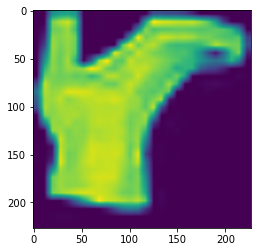

In [6]:
i = np.random.randint(50)
x, y = next(iter(train_dataloader))
plt.imshow(x[i].permute(1, 2, 0))

# Model

In [7]:
# class fasion_mnist_alexnet(nn.Module):  
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(96, 256, 5, 1, 2),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(256, 384, 3, 1, 1),
#             nn.ReLU()
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(384, 384, 3, 1, 1),
#             nn.ReLU()
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(384, 256, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2)
#         )

#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, 10)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.conv5(out)
#         out = out.view(out.size(0), -1)

#         out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
#         out = F.dropout(out, 0.5)
#         out = F.relu(self.fc2(out))
#         out = F.dropout(out, 0.5)
#         out = self.fc3(out)
#         out = F.log_softmax(out, dim=1)

#         return out


In [ ]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, num_classes)
          )

      if init_weights:
        self.initialize_weights()

  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

cfgs: Dict[str, List[Union[int, str]]] = {
    'A': [64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 1024, 1024, 1024, 'M'],
    'B': [64, 'M', 128, 'M', 256, 'M', 512, 'M', 1024, 'M'],
    'firstPadding':2
}

def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Module] = []
  in_channels = 3
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 11)
model = model.to(device)

In [8]:
model = fasion_mnist_alexnet().to(device)

# Loss function, Optimizer, Scheduler

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

# Train Model

In [10]:
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

{'train': 108000, 'val': 12000}


In [11]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [12]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train_model(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss))
      accuracies[phase].append(float(epoch_acc))
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    checkpoint(model, f"epoch-{epoch}.pth")
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [13]:
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def valid(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  
        print("\nValid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [15]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)


In [16]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 227731 KiB | 227731 KiB | 227731 KiB |      0 B   |\n|       from large pool | 227488 KiB | 227488 KiB | 227488 KiB |      0 B   |\n|       from small pool |    243 KiB |    243 KiB |    243 KiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         | 227731 KiB | 227731 KiB | 227731 KiB |      0 B   |\n|       from large pool | 227488 KiB | 227488 KiB |

In [17]:
epochs = 3
torch.cuda.empty_cache()

model = train_model(model, criterion, optimizer, scheduler, epochs)

In [ ]:
# torch.cuda.empty_cache()
# for epoch in range(1, 10+1):
#     train(model, device, train_dataloader, optimizer, epoch)
#     test(model, device, test_dataloader)

Train Epoch:1 [1856/114120 (2%)]	Loss: 2.348538
Train Epoch:1 [3776/114120 (3%)]	Loss: 1.456157
Train Epoch:1 [5696/114120 (5%)]	Loss: 1.209612
Train Epoch:1 [7616/114120 (7%)]	Loss: 0.908192
Train Epoch:1 [9536/114120 (8%)]	Loss: 0.870089
Train Epoch:1 [11456/114120 (10%)]	Loss: 0.837512
Train Epoch:1 [13376/114120 (12%)]	Loss: 0.773748
Train Epoch:1 [15296/114120 (13%)]	Loss: 0.697542
Train Epoch:1 [17216/114120 (15%)]	Loss: 0.928731
Train Epoch:1 [19136/114120 (17%)]	Loss: 0.764708
Train Epoch:1 [21056/114120 (18%)]	Loss: 0.636317
Train Epoch:1 [22976/114120 (20%)]	Loss: 0.397625
Train Epoch:1 [24896/114120 (22%)]	Loss: 0.646115
Train Epoch:1 [26816/114120 (23%)]	Loss: 0.566722
Train Epoch:1 [28736/114120 (25%)]	Loss: 0.837031
Train Epoch:1 [30656/114120 (27%)]	Loss: 0.541445
Train Epoch:1 [32576/114120 (29%)]	Loss: 0.658062
Train Epoch:1 [34496/114120 (30%)]	Loss: 0.915950
Train Epoch:1 [36416/114120 (32%)]	Loss: 0.518028
Train Epoch:1 [38336/114120 (34%)]	Loss: 0.559857
Train Epoc

TypeError: valid() takes 3 positional arguments but 5 were given